## Imports

In [1]:
import sys,re, os, glob, json, string, pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from snowballstemmer import TurkishStemmer 
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from difflib import SequenceMatcher
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Global Variables

In [2]:
word_size_threshold = 100
similarity_ratio = 0.90
top_crime_number = 10

#path = "datasets/*.json"
path = "../datasets/*.json" 

## this config variables to disable cells for next runs to avoid doing unnecessary processes
create_data_json = False
enable_preprocessing = False

## Read Datasets

In [3]:
files = glob.glob(path)

json_arr = []
for file in files:
    f = open(file, "r", encoding='utf-8')
    jsonData = json.loads(f.read())
    json_arr.append(jsonData)


KeyboardInterrupt: 

In [ ]:
## Create labels from dataset

if(not create_data_json):
    raise Exception("NOT ERROR - SKIPPINIG")

# To check if a dictionary has a key or not
def  has_key(dict, key):
    return True if key in dict.keys() else False

labels = {} 

def replaceTurkishCharacters(txt):
    return txt.replace('Ğ','g').replace('Ü','u').replace('Ş','s').replace('I','i').replace('İ','i').replace('Ö','o').replace('Ç','c').replace('ğ','g').replace('ü','u').replace('ş','s').replace('ı','i').replace('ö','o').replace('ç','c')



# Get all "Mahkemesi" labels with their frequency
def readLabels(jsonData):    
    key = replaceTurkishCharacters(jsonData["Mahkemesi"]).replace('...','').strip().lower() if jsonData["Mahkemesi"] != '' else "undefined"
    key = ' '.join(key.split())
    if (not has_key(labels, key)):
        
        #print(key)
        labels[key] = 1    
    else :
        labels[key] = labels[key] + 1

for file in json_arr: 
    readLabels(file)

similar_words = {}    
    
for label in labels.keys():
    if 'bolge adliye mahkemesi' in label:
        similar_words[label] = 'bolge adliye mahkemesi'
    elif label == 'asliye hukuk (is) mahkemesi':
        similar_words[label] = 'is mahkemesi'
    elif label == 'aile mahkemesi':
        similar_words[label] = 'cocuk mahkemesi'
    elif label == 'cocuk agir ceza mahkemesi':
        similar_words[label] = 'cocuk mahkemesi'
    elif label == 'asliye hukuk (aile) mahkemesi':
        similar_words[label] = 'asliye hukuk mahkemesi'
    
# convert dictionary items(labels) to arrays and sort them
items = list(map(lambda x: list(x), labels.items()))
labels_array = sorted(items, key=lambda x: x[1], reverse=True)

# Filter labels with 1 frequency
array_final = (list(filter(lambda x: x[1] > 1 , labels_array)))

# Sort by frequency
array_final = sorted(array_final, key=lambda x: x[1], reverse=True)

# Save labels with frequencies to data.json
jsonString = json.dumps(array_final, indent = 4, ensure_ascii=False)
jsonFile = open("data.json", "w", encoding='utf-8')
jsonFile.write(jsonString)
jsonFile.close()


## Read data.json

In [ ]:
if(not enable_preprocessing):
    raise Exception("NOT ERROR - SKIPPINIG")
    
ictihats = []
suc_array = []

# Get top 10 crimes from data.json
top_crimes = []
top_results = []
with open("data.json", encoding='utf-8') as jsonFile:
    data = json.load(jsonFile)
    top_crimes = list(map(lambda x: x[0], data[:top_crime_number]))
    top_results = list(map(lambda x: x[1], data[:top_crime_number]))


# Get all ictihat and suç from dataset
# if a crime similar with any of top_crimes, then use the crime in top_crimes
for jsonData in json_arr:
    key = replaceTurkishCharacters(jsonData["Mahkemesi"]).replace('...','').strip().lower() if jsonData["Mahkemesi"] != '' else "undefined"
    key = ' '.join(key.split())
    if (key !="undefined" and key in similar_words):
        key = similar_words[key]
    
    #key = similar_suc if similar_suc is not None else key
    suc = key if key in top_crimes or key == 'undefined' else "other"

    new_ictihat = jsonData['ictihat'].strip()
    ictihats.append(new_ictihat)
    new_ictihat_ctr = new_ictihat.split()
    num_of_words = len(new_ictihat_ctr)
    suc_array.append(suc.strip())
    

In [ ]:

if(not enable_preprocessing):
    raise Exception("NOT ERROR - SKIPPINIG")

# Draw top crimes label/frequency chart
def draw_chart(options):
    print("\n--------",options["title"],"--------")
    data = pd.read_csv(options["file"]) 
    words = []
    words = data.head(15)[data.columns[0]]
    freqs = data.head(15)[data.columns[1]]
    colors = ['#bc80bd', '#fb8072', '#80b1d3', '#8dd3c7', '#fdb462',
              '#b3de69', '#bebada', '#F3D1B0', '#fccde5', '#d9d9d9']

    reversed_words = words[::-1]
    reversed_freqs = freqs[::-1]

    plt.barh(reversed_words, reversed_freqs, color=colors)
    plt.ylabel("labels")
    plt.xlabel("occurences")
    plt.title(options["title"])
    plt.show()
    
df_chart = pd.DataFrame(columns= {'crimes', 'results'})
df_chart['crimes'] = top_crimes
df_chart['results'] = top_results
df_chart.to_csv('chart.csv', encoding='utf-8', index = False)

draw_chart({"file": 'chart.csv', "title": "Labels and their corresponding occurences"})

## Preprocessing

In [ ]:
if(not enable_preprocessing):
    raise Exception("NOT ERROR - SKIPPINIG")

# lower all words in a ictihat
ictihats_lower = []
for i in ictihats:
    i = i.lower()
    ictihats_lower.append(i)
    
ictihats_punctuation = []

file = open("stopwords.txt", "r", newline='', encoding='utf-8')
result = file.read()
stopwords = word_tokenize(result)

# Punctuation and remove stopwords
for ictihat in ictihats_lower:
    ictihat = ictihat.translate(str.maketrans("", "", string.punctuation))
    tokenized_words = ([word for word in ictihat.split() if word not in stopwords and len(word) > 1 and re.match("^[A-Z0-9a-zğüşöçİĞÜŞÖÇ]*$", word)])
    ictihats_punctuation.append(' '.join(tokenized_words[:word_size_threshold]))

# stemming words
turkStem = TurkishStemmer()
for index, ictihat in enumerate(ictihats_punctuation,start=0):
    ictihats_punctuation[index] = ' '.join([turkStem.stemWord(word) for word in ictihat.split()])


## write data into csv file

In [ ]:
if(not enable_preprocessing):
    raise Exception("NOT ERROR - SKIPPINIG")

# Save all preprocessed ictihat - suç to avoid processing in later runs 
df = pd.DataFrame(columns = ['ictihats', 'mahkemes'])
df['ictihats'] = ictihats_punctuation
df['mahkemes'] = suc_array
csv_file_name = 'train_set_' + str(word_size_threshold) + '.csv'

df.to_csv(csv_file_name, encoding='utf-8', index=False)


## Read train set from CSV

In [4]:
# if CSV is exist from previos run, use it to get ictihat - suç occurrences
csv_file_name = 'train_set_' + str(word_size_threshold) + '.csv'
my_csv = pd.read_csv(csv_file_name, dtype=str, na_filter=False)

ictihats_punctuation = my_csv['ictihats'].tolist()
suc_array = my_csv['mahkemes'].tolist()


## Split Dataset

In [5]:
# Split dataset by 80 - 20
x_train, x_test, y_train, y_test = train_test_split(ictihats_punctuation, 
                                                    suc_array, 
                                                    test_size=0.20,random_state=36)

## Vectorize

In [6]:
# Use Tfidf vectorizer to transform train and test set
tfidfvectorizer = TfidfVectorizer(analyzer='word')
training_data = tfidfvectorizer.fit_transform(x_train)
testing_data = tfidfvectorizer.transform(x_test)


## Support Vector Machines (specifically linear SVM)

                        precision    recall  f1-score   support

   agir ceza mahkemesi       0.81      0.61      0.69       374
 asliye ceza mahkemesi       0.89      0.95      0.92      1979
asliye hukuk mahkemesi       0.75      0.82      0.79       389
bolge adliye mahkemesi       0.92      0.91      0.92       477
          ceza dairesi       0.97      0.96      0.96       218
       cocuk mahkemesi       0.53      0.59      0.56       182
          is mahkemesi       0.91      0.94      0.92       266
                 other       0.82      0.55      0.66       273
     ticaret mahkemesi       0.73      0.48      0.58        75
             undefined       0.92      0.93      0.92      1338

              accuracy                           0.87      5571
             macro avg       0.83      0.77      0.79      5571
          weighted avg       0.87      0.87      0.87      5571



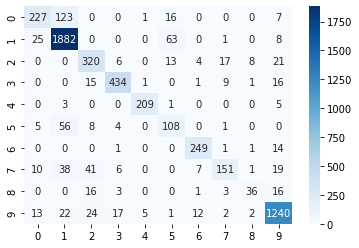

In [7]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(training_data, y_train)
y_pred = svclassifier.predict(testing_data)

cf_matrix = confusion_matrix(y_test,y_pred)

ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')
print(classification_report(y_test,y_pred))

## Multinomial Naive Bayes

c:\users\anlsn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\anlsn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\anlsn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                        precision    recall  f1-score   support

   agir ceza mahkemesi       1.00      0.01      0.02       374
 asliye ceza mahkemesi       0.67      0.99      0.80      1979
asliye hukuk mahkemesi       0.88      0.38      0.53       389
bolge adliye mahkemesi       0.81      0.76      0.78       477
          ceza dairesi       1.00      0.05      0.10       218
       cocuk mahkemesi       0.00      0.00      0.00       182
          is mahkemesi       0.94      0.25      0.40       266
                 other       1.00      0.01      0.02       273
     ticaret mahkemesi       0.00      0.00      0.00        75
             undefined       0.53      0.77      0.63      1338

              accuracy                           0.64      5571
             macro avg       0.68      0.32      0.33      5571
          weighted avg       0.70      0.64      0.56      5571



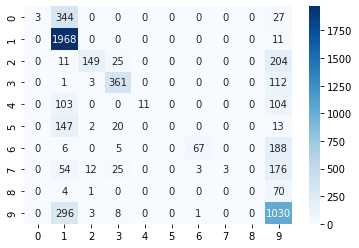

In [8]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

cf_matrix = confusion_matrix(y_test,predictions)

ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')
print(classification_report(y_test,predictions))


## Logistic Regression

c:\users\anlsn\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                        precision    recall  f1-score   support

   agir ceza mahkemesi       0.79      0.61      0.69       374
 asliye ceza mahkemesi       0.87      0.96      0.91      1979
asliye hukuk mahkemesi       0.76      0.80      0.78       389
bolge adliye mahkemesi       0.91      0.91      0.91       477
          ceza dairesi       0.97      0.93      0.95       218
       cocuk mahkemesi       0.56      0.48      0.52       182
          is mahkemesi       0.92      0.90      0.91       266
                 other       0.82      0.52      0.64       273
     ticaret mahkemesi       0.76      0.43      0.55        75
             undefined       0.89      0.92      0.90      1338

              accuracy                           0.86      5571
             macro avg       0.83      0.75      0.78      5571
          weighted avg       0.86      0.86      0.86      5571



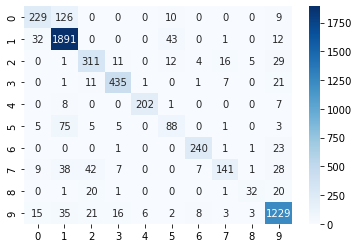

In [9]:
log_regres_classifier = LogisticRegression(random_state = 36)
log_regres_classifier.fit(training_data, y_train)
y_pred = log_regres_classifier.predict(testing_data)
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')
print(classification_report(y_test,y_pred))
